In [4]:
from brian2 import *
%matplotlib inline

start_scope()


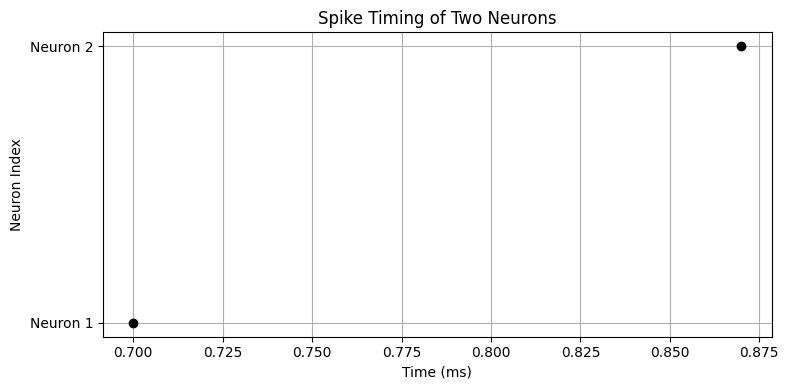

In [2]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Setup
start_scope()
defaultclock.dt = 0.01*ms

# Parameters
input_value = 0.7  # value to encode as time offset (0.0–1.0)
input_time = input_value * ms
weight = 8.0  # sigmoid weight control
duration = 3*ms

# Sigmoid timing transformation
def transform_time(t, w):
    return 1.0 / (1.0 + np.exp(w * (t - 0.5)))

# Input spike
input_indices = [0]
input_times = [input_time]
input_group = SpikeGeneratorGroup(1, input_indices, input_times*second)

# Neuron model (dummy, spikes manually triggered)
G = NeuronGroup(2, 'v:1', threshold='v>1', reset='v=0', method='exact')

# Record spikes
spike_mon = SpikeMonitor(G)

stimulated = False  # outside network_operation

@network_operation(dt=0.01*ms)
def stimulate_first():
    global stimulated
    if not stimulated and defaultclock.t >= input_time:
        G.v[0] = 1.1
        stimulated = True

# Schedule second neuron to spike after sigmoid transform
has_spiked = False

@network_operation(dt=0.01*ms)
def transformed_spike():
    global has_spiked
    if not has_spiked and len(spike_mon.t) > 0:
        t_spike_1 = spike_mon.t[0]/ms  # Neuron 0 spike time
        # Apply timing transform
        delay = transform_time(t_spike_1 / 1.0, weight) * ms
        t_spike_2 = t_spike_1 * ms + delay
        if defaultclock.t >= t_spike_2:
            G.v[1] = 1.1
            has_spiked = True

run(duration)

# Plot
plt.figure(figsize=(8, 4))
plt.title("Spike Timing of Two Neurons")
plt.plot(spike_mon.t/ms, spike_mon.i, 'ko')
plt.yticks([0, 1], ['Neuron 1', 'Neuron 2'])
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Index")
plt.grid(True)
plt.tight_layout()
plt.show()


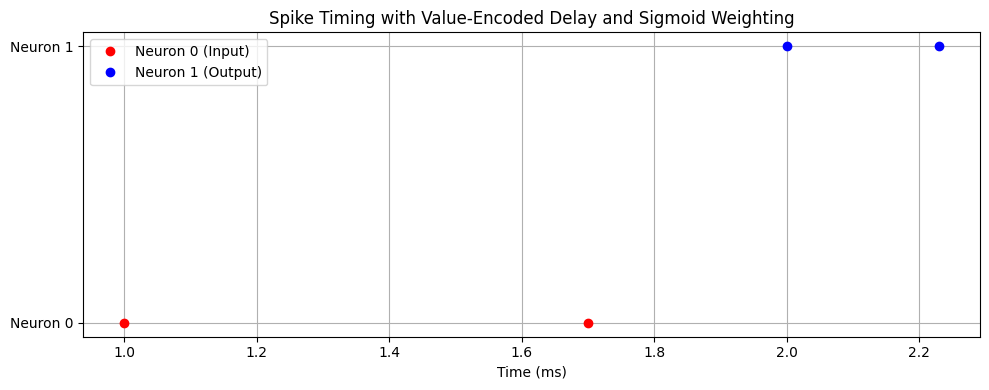

In [6]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

# Setup
start_scope()
defaultclock.dt = 0.01*ms

# Parameters
input_value = 0.7  # delay from start spike (in ms)
weight = 6.0       # sigmoid weight
duration = 5*ms

# Sigmoid function to compress value timing
def transform_delay(delta, w):
    return 1.0 / (1.0 + np.exp(w * (delta - 0.5)))

# Transformed output delay
delta_out = transform_delay(input_value, weight)

# Input spike times: start at 1.0 ms, value spike at 1.0 + input_value
input_times = [1.0, 1.0 + input_value]*ms
input_indices = [0, 0]
input_group = SpikeGeneratorGroup(1, input_indices, input_times)

# Output spike times: start at 2.0 ms, value spike at 2.0 + delta_out
output_times = [2.0, 2.0 + delta_out]*ms
output_indices = [0, 0]
output_group = SpikeGeneratorGroup(1, output_indices, output_times)

# Spike monitors
mon_input = SpikeMonitor(input_group)
mon_output = SpikeMonitor(output_group)

# Run the network
run(duration)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(mon_input.t/ms, [0]*len(mon_input.t), 'ro', label='Neuron 0 (Input)')
plt.plot(mon_output.t/ms, [1]*len(mon_output.t), 'bo', label='Neuron 1 (Output)')
plt.yticks([0, 1], ['Neuron 0', 'Neuron 1'])
plt.xlabel("Time (ms)")
plt.title("Spike Timing with Value-Encoded Delay and Sigmoid Weighting")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.03605277967659715, Weight: 6.003343834631226
Epoch 10, Loss: 0.03637249310384811, Weight: 6.036797286526891
Epoch 20, Loss: 0.03669271176906764, Weight: 6.070277034316269
Epoch 30, Loss: 0.03701340417124107, Weight: 6.103781412131964
Epoch 40, Loss: 0.03733453884090125, Weight: 6.1373087594811935
Epoch 50, Loss: 0.037656084354497445, Weight: 6.170857421732858
Epoch 60, Loss: 0.037978009348593154, Weight: 6.204425750596879
Epoch 70, Loss: 0.03830028253388021, Weight: 6.238012104595511
Epoch 80, Loss: 0.03862287270899605, Weight: 6.271614849526308
Epoch 90, Loss: 0.03894574877413262, Weight: 6.305232358916484
Final weight after training: 6.335499403281435


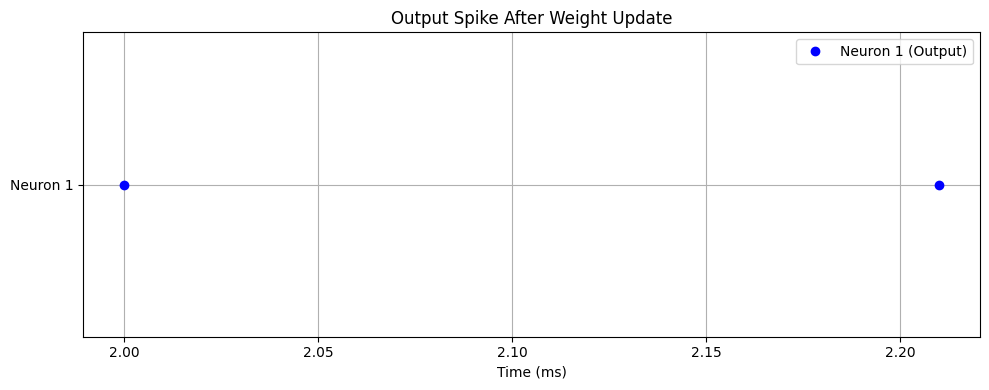

In [ ]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

# Setup
start_scope()
defaultclock.dt = 0.01*ms

# Parameters
input_value = 0.7  # delay from start spike (in ms)
initial_weight = 6.0  # initial weight
learning_rate = 0.1  # learning rate for gradient descent
duration = 5*ms

# Sigmoid function to compress value timing
def transform_delay(delta, w):
    return 1.0 / (1.0 + np.exp(w * (delta - 0.5)))

# Loss function (Mean Squared Error)
def loss_function(true_value, predicted_value):
    return 0.5 * (true_value - predicted_value)**2

# Gradient of the loss function with respect to the weight
def compute_gradients(true_value, predicted_value, input_value, weight):
    # Compute the derivative of the sigmoid with respect to the weight
    sigmoid_derivative = np.exp(weight * (input_value - 0.5)) / (1 + np.exp(weight * (input_value - 0.5)))**2
    error = predicted_value - true_value
    # Gradient of the loss with respect to weight (simplified)
    gradient = error * sigmoid_derivative * input_value  # Propagate error through sigmoid and timing
    return gradient

# Initial weight
weight = initial_weight

# Simulate the forward pass and calculate the output
def simulate_forward_pass(input_value, weight):
    delta_out = transform_delay(input_value, weight)
    # Simulate the spikes (start spike at 2ms, value spike at 2ms + delta_out)
    return delta_out

# Training loop
epochs = 100
for epoch in range(epochs):
    # Forward pass to get predicted output
    predicted_value = simulate_forward_pass(input_value, weight)
    
    # Compute the true value we want to compare against
    true_value = 0.5  # This is the desired output spike time (for example)
    
    # Calculate the loss
    loss = loss_function(true_value, predicted_value)
    
    # Compute the gradient of the loss with respect to the weight
    gradient = compute_gradients(true_value, predicted_value, input_value, weight)
    
    # Update the weight using gradient descent
    weight -= learning_rate * gradient
    
    # Optionally print loss to track progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}, Weight: {weight}")

# Final weight after training
print(f"Final weight after training: {weight}")

# Plotting (for visualization)
plt.figure(figsize=(10, 4))

# Final simulation after training
final_delta_out = simulate_forward_pass(input_value, weight)
final_output_times = [2.0, 2.0 + final_delta_out] * ms
output_indices = [0, 0]
output_group = SpikeGeneratorGroup(1, output_indices, final_output_times)

# Spike monitor
mon_output = SpikeMonitor(output_group)

# Run the network after training
run(duration)

# Plot spikes
plt.plot(mon_output.t/ms, [1]*len(mon_output.t), 'bo', label='Neuron 1 (Output)')
plt.yticks([1], ['Neuron 1'])
plt.xlabel("Time (ms)")
plt.title("Output Spike After Weight Update")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
    